In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
nasdaq = pd.read_csv('Daily Nasdaq Trading Strategy v2.csv')
nasdaq.head(10)

,PERMNO,date,SICCD,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,...,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_10,move_avg_20,move_avg_30,lasso_pred,pred_forest,log_pred
0,10104,2023-02-14,7372,ORCL,ORACLE CORP,-1.277230,-1.271494,-1.241274,-0.233761,-0.260484,...,7,0,0,1,0,0,0,-0.000238,-0.004098,Negative
1,10104,2023-02-15,7372,ORCL,ORACLE CORP,-1.250367,-1.287763,-1.303459,-0.674966,-0.509022,...,7,0,0,0,0,0,0,-0.000592,-0.006247,Negative
2,10104,2023-02-16,7372,ORCL,ORACLE CORP,-1.335777,-1.364225,-1.354865,-0.449486,-0.435428,...,7,0,0,0,0,0,0,-0.001336,0.000916,Negative
3,10104,2023-02-17,7372,ORCL,ORACLE CORP,-1.377970,-1.432552,-1.391347,-0.385708,-0.330188,...,7,0,0,0,0,0,0,-0.000587,-0.014647,Positive
4,10104,2023-02-21,7372,ORCL,ORACLE CORP,-1.408191,-1.472410,-1.480894,-0.544911,-0.716978,...,7,0,0,0,1,1,0,-0.000180,0.000554,Negative
5,10104,2023-02-22,7372,ORCL,ORACLE CORP,-1.422463,-1.452888,-1.470944,-0.463814,0.006663,...,7,0,0,0,1,1,0,0.000611,0.012626,Positive
6,10104,2023-02-23,7372,ORCL,ORACLE CORP,-1.331798,-1.265800,-1.283560,-0.072572,1.309805,...,7,0,0,0,0,0,0,-0.000341,0.002856,Positive
7,10104,2023-02-24,7372,ORCL,ORACLE CORP,-1.325082,-1.313792,-1.276926,-0.209365,-0.019043,...,7,0,0,0,0,0,0,-0.001016,-0.004874,Negative
8,10104,2023-02-27,7372,ORCL,ORACLE CORP,-1.306613,-1.307285,-1.334966,-0.336699,-0.481530,...,7,0,0,0,0,0,0,-0.000478,-0.012085,Negative
9,10104,2023-02-28,7372,ORCL,ORACLE CORP,-1.321724,-1.385374,-1.381397,-0.236075,-0.401207,...,7,0,1,1,0,0,0,-0.000032,-0.010215,Negative


In [3]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24186 entries, 0 to 24185
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PERMNO            24186 non-null  int64  
 1   date              24186 non-null  object 
 2   SICCD             24186 non-null  int64  
 3   TICKER            24186 non-null  object 
 4   COMNAM            24186 non-null  object 
 5   BIDLO             24186 non-null  float64
 6   ASKHI             24186 non-null  float64
 7   PRC               24186 non-null  float64
 8   VOL               24186 non-null  float64
 9   RET               24186 non-null  float64
 10  SHROUT            24186 non-null  float64
 11  RETX              24186 non-null  float64
 12  sprtrn            24186 non-null  float64
 13  positive          24186 non-null  int64  
 14  negative          24186 non-null  int64  
 15  total             24186 non-null  int64  
 16  market_cap        24186 non-null  float6

In [4]:
# Change PERMNO column to object
nasdaq['PERMNO'] = nasdaq['PERMNO'].astype(str)

# Change date column to datetime with %Y-%m-%d format
nasdaq['date'] = pd.to_datetime(nasdaq['date'], format='%Y-%m-%d')

# Change SICCD column to object
nasdaq['SICCD'] = nasdaq['SICCD'].astype(str)

# Change proper. column to object
nasdaq['proper'] = nasdaq['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(nasdaq.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24186 entries, 0 to 24185
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PERMNO            24186 non-null  object        
 1   date              24186 non-null  datetime64[ns]
 2   SICCD             24186 non-null  object        
 3   TICKER            24186 non-null  object        
 4   COMNAM            24186 non-null  object        
 5   BIDLO             24186 non-null  float64       
 6   ASKHI             24186 non-null  float64       
 7   PRC               24186 non-null  float64       
 8   VOL               24186 non-null  float64       
 9   RET               24186 non-null  float64       
 10  SHROUT            24186 non-null  float64       
 11  RETX              24186 non-null  float64       
 12  sprtrn            24186 non-null  float64       
 13  positive          24186 non-null  int64         
 14  negative          2418

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'tomorrow_return' column
nasdaq.dropna(subset=['tomorrow_return'], inplace=True)

# Select only numeric columns
numeric_columns = nasdaq.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[nasdaq['tomorrow_return'] >= 0]
negative_return = numeric_columns[nasdaq['tomorrow_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_tomorrow_return'] = mean_negative_return
result_df['mean_positive_tomorrow_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                  negative_tomorrow_return  mean_positive_tomorrow_return  \
BIDLO                                0.057                         -0.054   
ASKHI                                0.057                         -0.054   
PRC                                  0.056                         -0.053   
VOL                                 -0.031                          0.034   
RET                                 -0.006                          0.007   
SHROUT                               0.022                         -0.018   
RETX                                -0.006                          0.007   
sprtrn                              -0.014                          0.020   
positive                             0.083                          0.085   
negative                             0.004                          0.005   
total                                0.575                          0.592   
market_cap                           0.058                         -0.054   

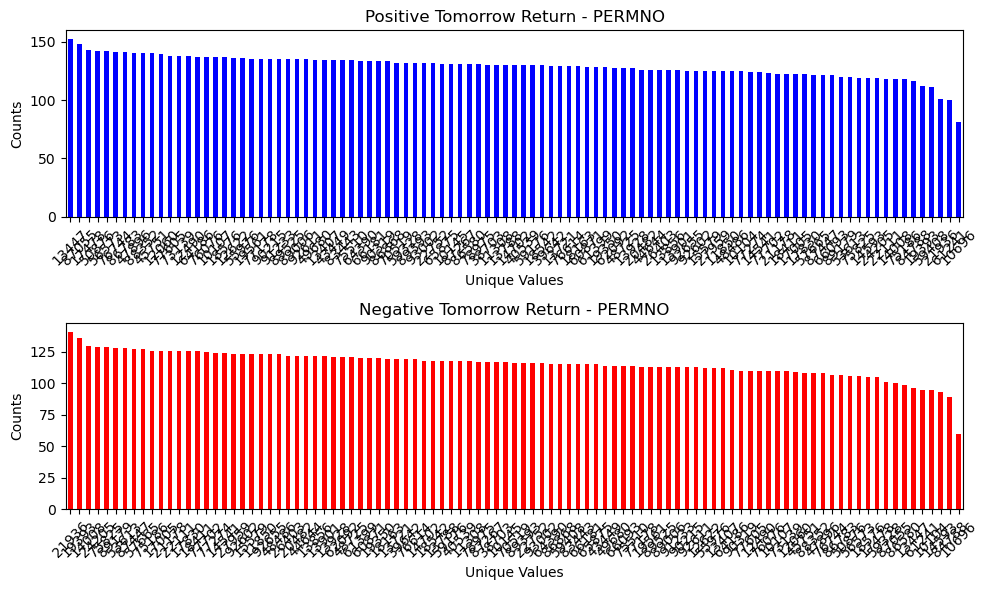

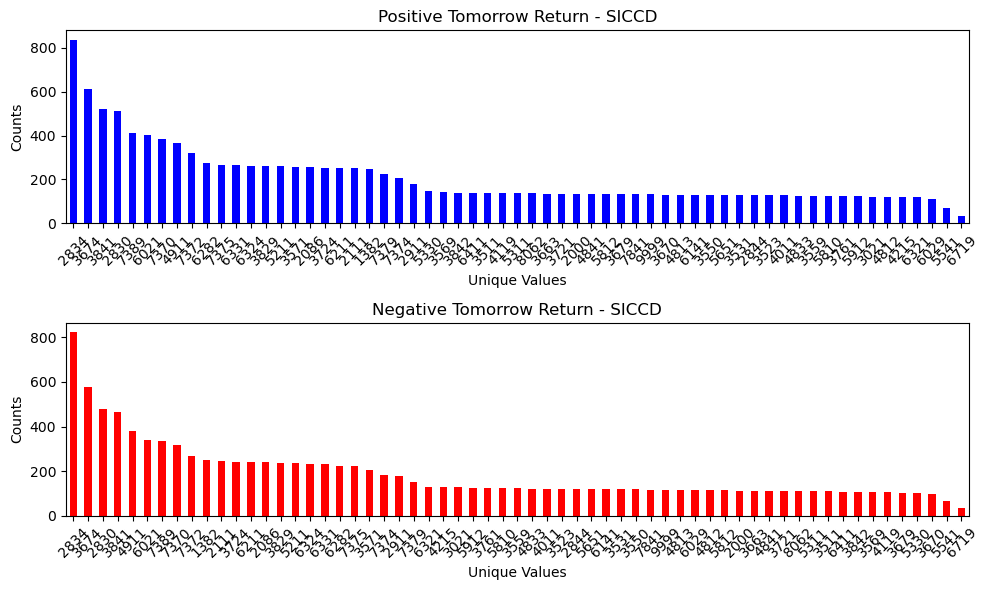

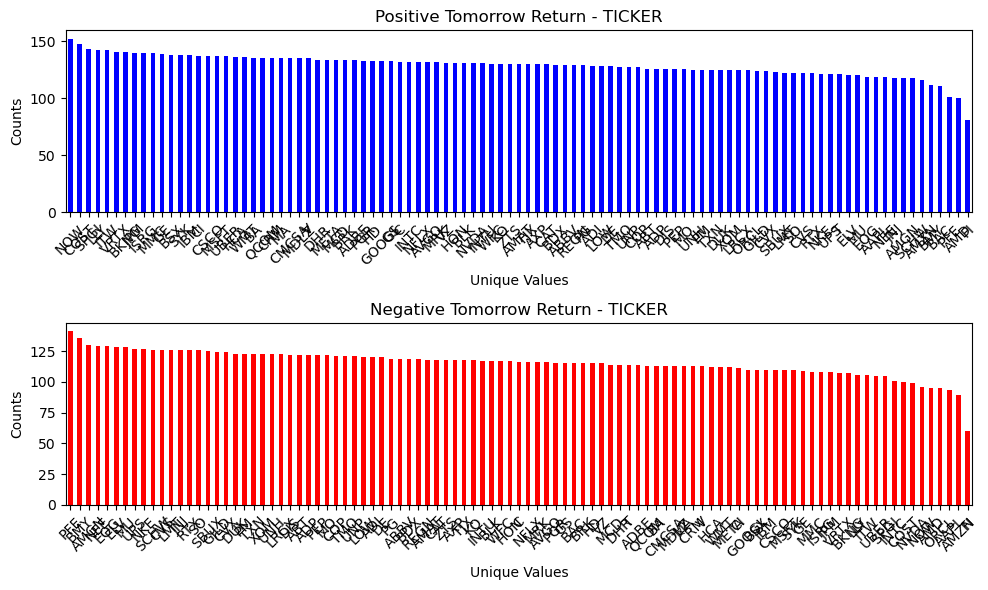

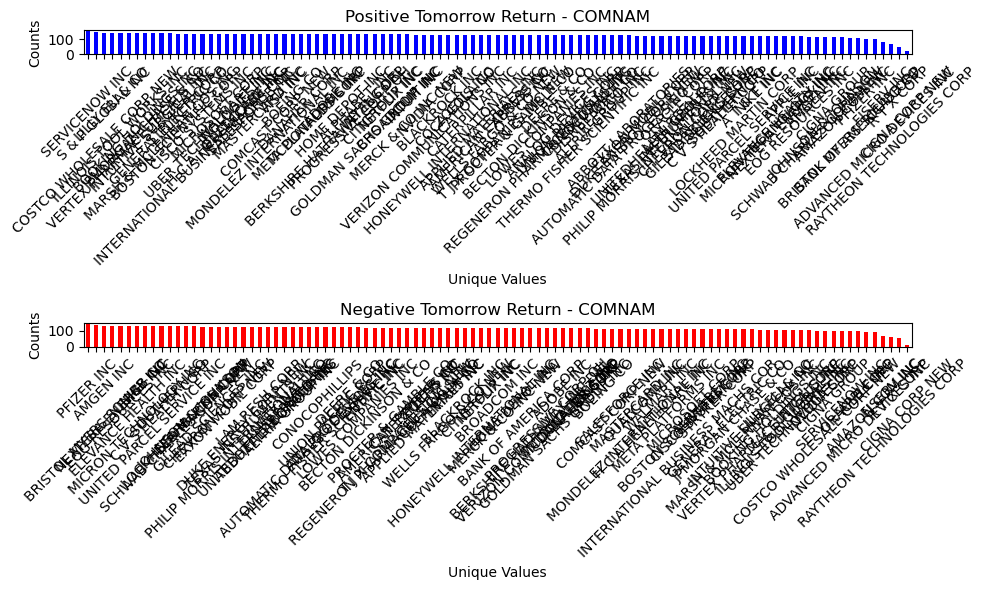

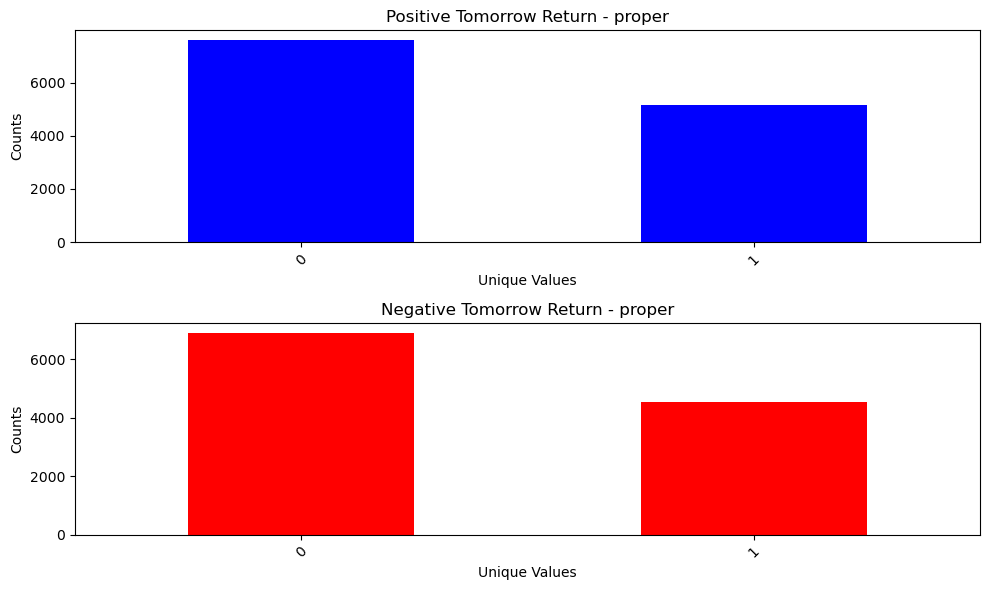

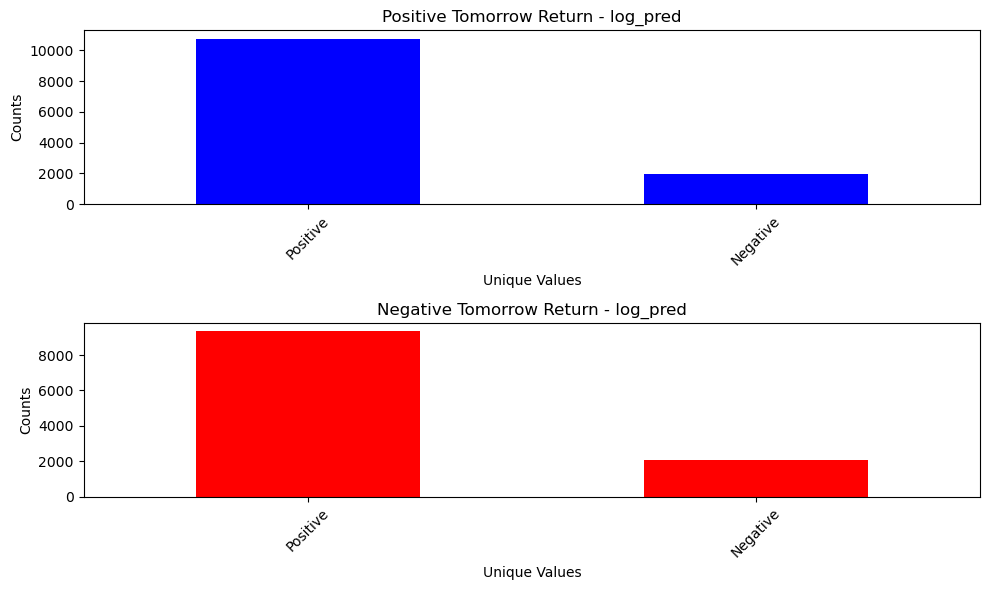

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'tomorrow_return' column
nasdaq.dropna(subset=['tomorrow_return'], inplace=True)

# Select only categorical columns
categorical_columns = nasdaq.select_dtypes(include=['object'])

# Create subsets
positive_return = nasdaq[nasdaq['tomorrow_return'] >= 0]
negative_return = nasdaq[nasdaq['tomorrow_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

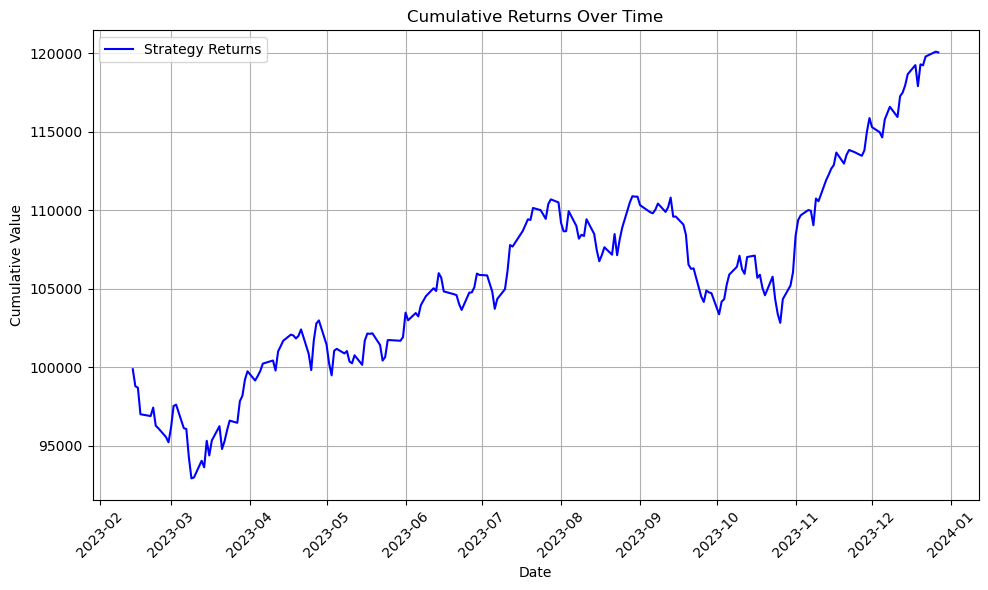

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy.loc[(nasdaq_copy['dummy_total'] == 1), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


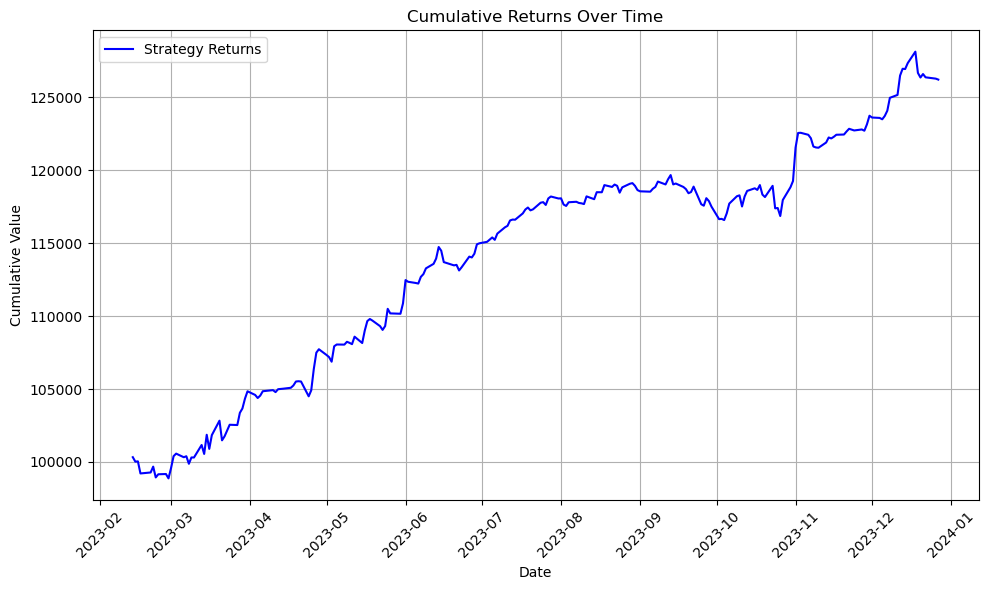

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] > 0), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


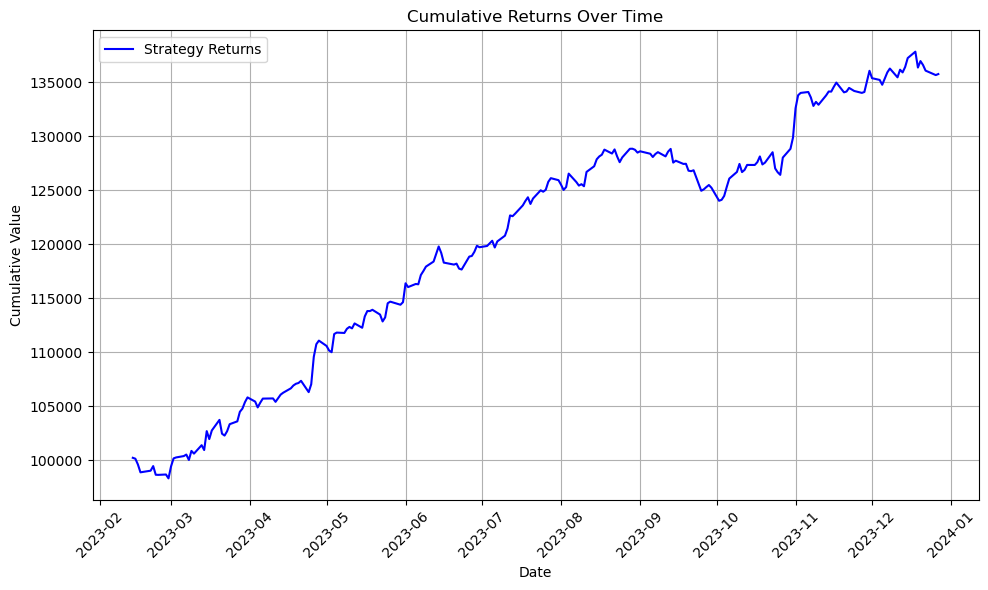

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


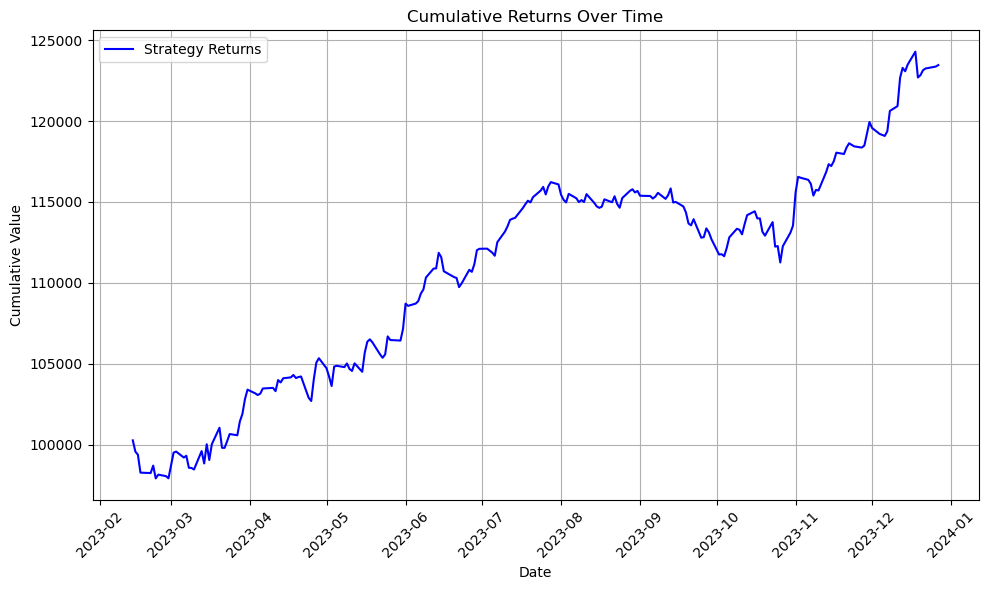

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Positive'), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


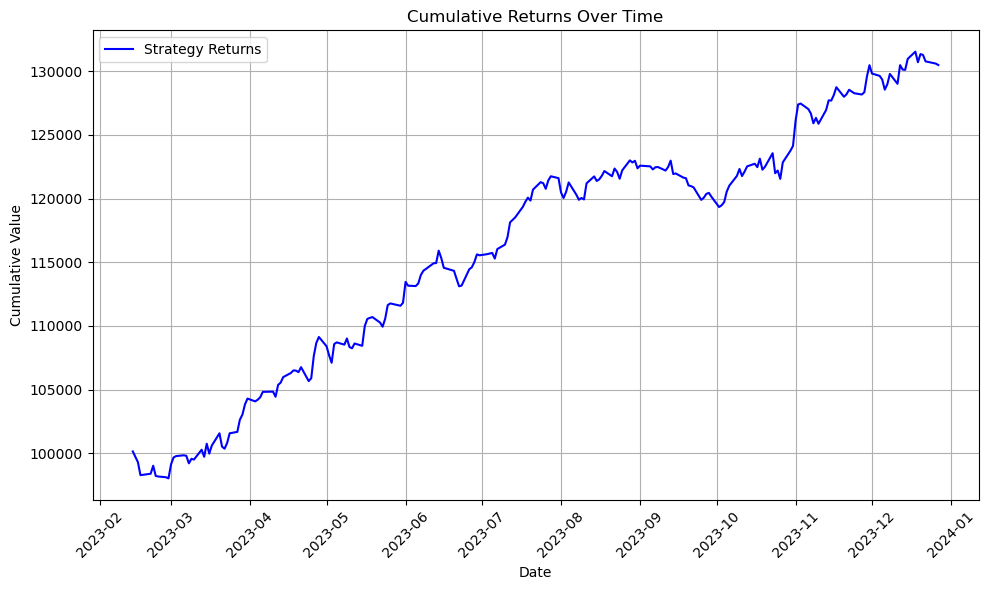

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Positive') & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Negative') & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


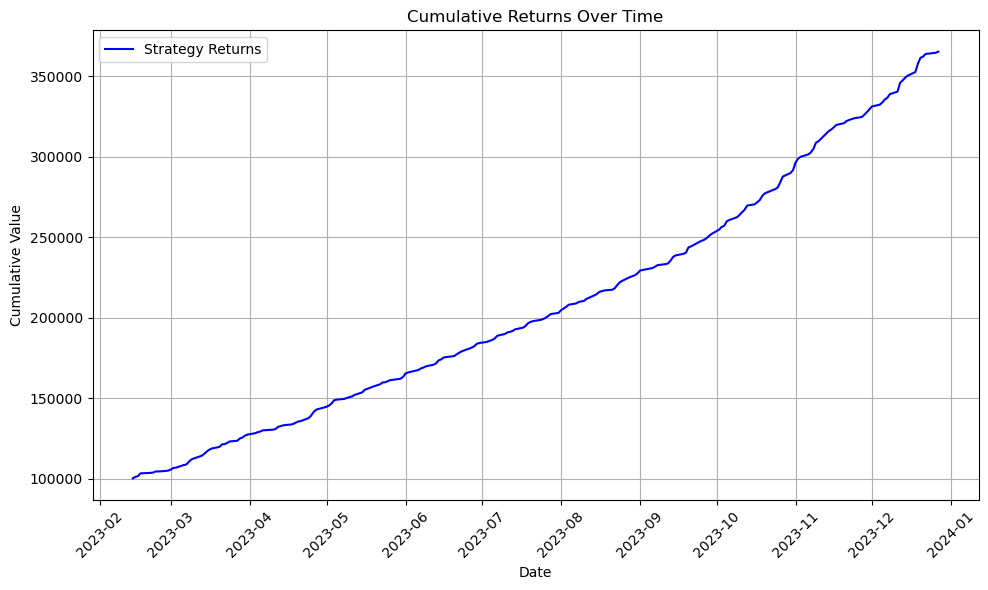

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


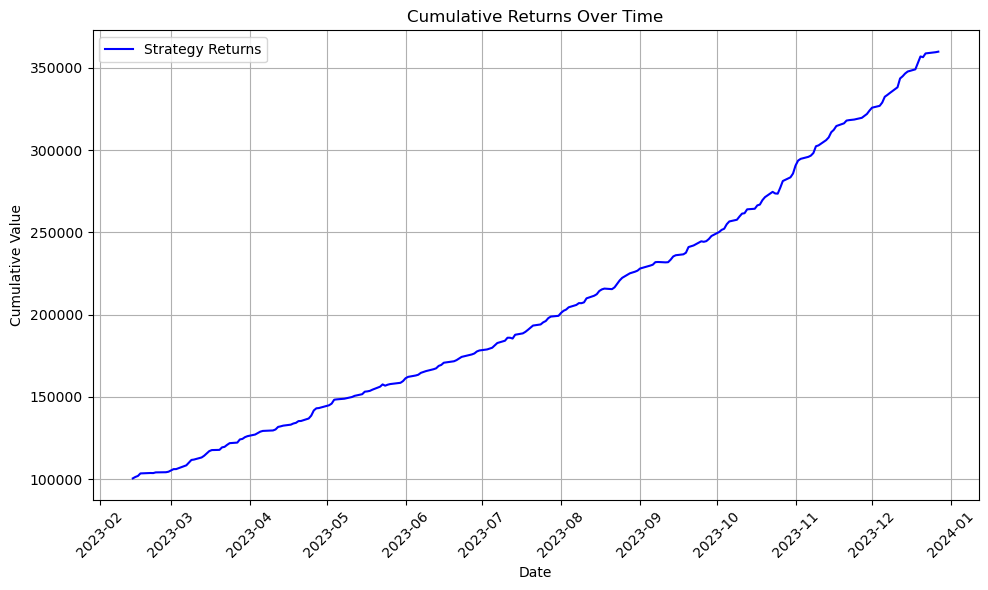

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


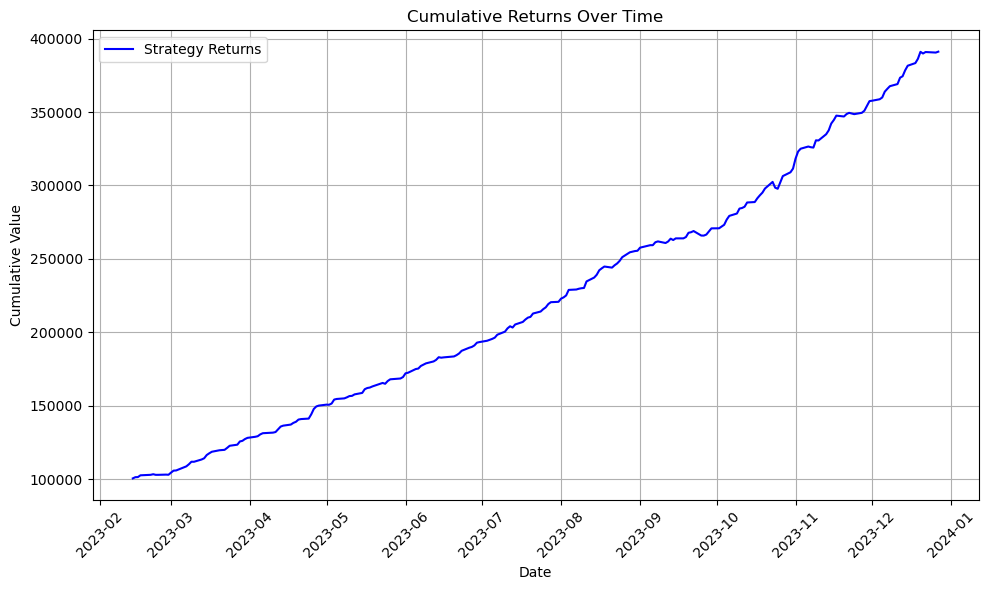

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\joel3\AppData\Local\Temp\ipykernel_22452\3393393553.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)


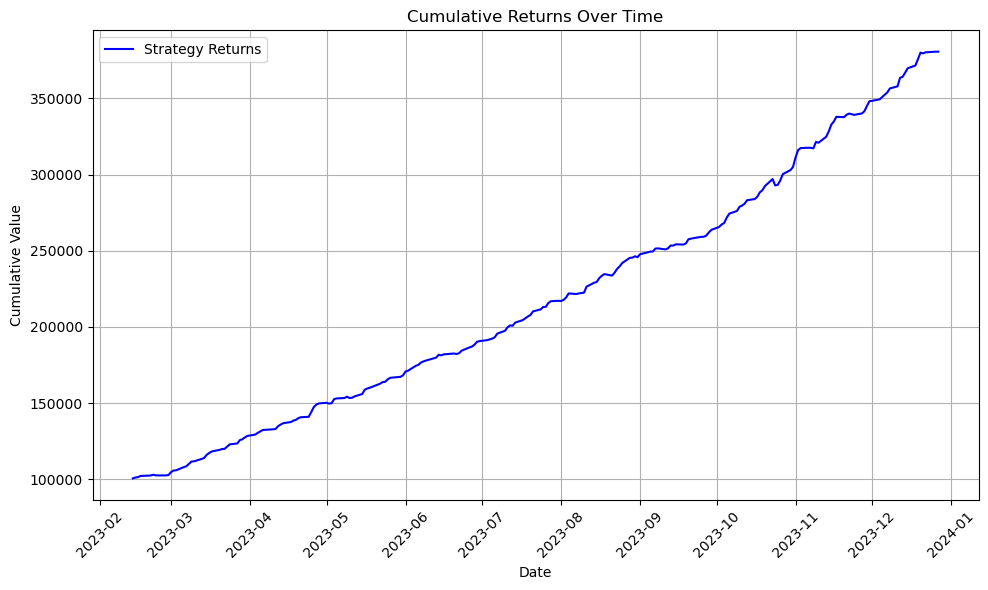

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['log_pred'] == 'Positive') & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['log_pred'] == 'Negative') & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


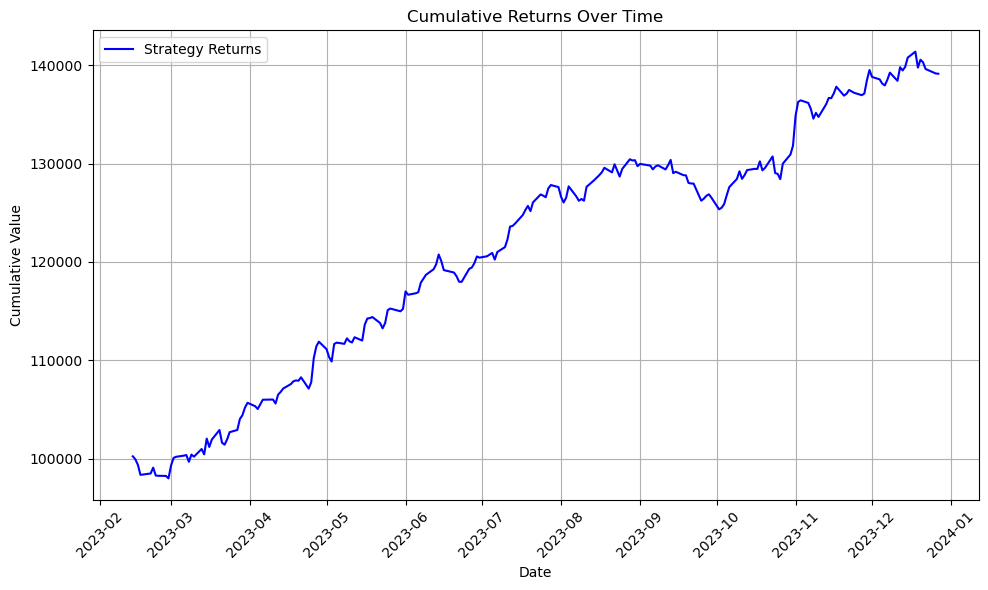

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Positive') & (nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Negative') & (nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\joel3\AppData\Local\Temp\ipykernel_22452\3904538385.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)


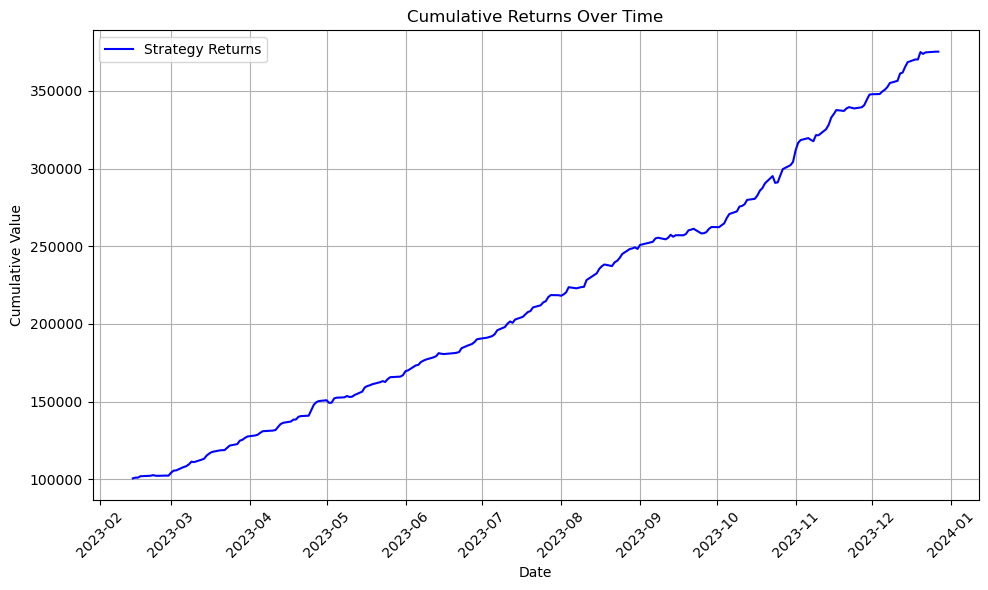

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1) & (nasdaq_copy['log_pred'] == 'Positive'), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1) & (nasdaq_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate daily mode of 'sprtrn' for S&P 500
daily_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = daily_mode_sprtrn[daily_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['tomorrow_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
